# ML Model For Gold Recovery

# INTRODUCTION

**During the course of this project we will attempt to Predict the amount of gold recovered based on input parameters related to the ore, processing conditions, and other relevant factors.After collecting the data we will perform some EDA, models will be selected follow by some training and some key metrics will be evaluated.The best performing model will be used to test the test samples**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
#from itertools import product
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
#from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import seaborn as sns


# 1.1. Open the files and look into the data.

**df_1**

In [2]:
df_1 = pd.read_csv('/datasets/gold_recovery_train.csv')
#df_1.info()

In [3]:
df_1.shape

(16860, 87)

In [4]:
df_1.duplicated().sum()

0

In [5]:
df_1.isnull().sum().sum()

30320

In [6]:
df_1['date'] = pd.to_datetime(df_1['date'], errors='coerce')


**df_2**

In [7]:
df_2 = pd.read_csv('/datasets/gold_recovery_test.csv')
#df_2.info()

In [8]:
df_2.shape

(5856, 53)

In [9]:
df_2.duplicated().sum()

0

In [10]:
df_2.isnull().sum().sum()

2360

In [11]:
df_2['date'] = pd.to_datetime(df_2['date'])


**df_3**

In [12]:
df_3 = pd.read_csv('/datasets/gold_recovery_full.csv')
#df_3.info()


In [13]:
df_3.shape

(22716, 87)

In [14]:
df_3.duplicated().sum()

0

In [15]:
df_3.isnull().sum().sum()

36587

In [16]:
df_3['date'] = pd.to_datetime(df_3['date'])


# 1.2. Check that recovery is calculated correctly

**1.2.1 calculate recovery for the rougher.output.recovery feature.**

In [17]:
# we fix and extra clean some keys columns before calculation
df_1 = df_1[
    (df_1['rougher.input.feed_au'].abs().ne(float('inf'))) &
    
    (df_1['rougher.output.tail_au'].abs().ne(float('inf'))) & 
    
    (df_1['rougher.output.concentrate_au'].abs().ne(float('inf'))) & 
    
    (df_1['rougher.output.tail_au'] != 0) &
    
    (df_1['rougher.output.concentrate_au'] != 0) & 
    
    (df_1['rougher.input.feed_au'] != 0)]

In [18]:
# Check again for zeros in key columns.(min)
display(df_1[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']].describe())

,rougher.input.feed_au,rougher.output.concentrate_au,rougher.output.tail_au
count,15241.000000,15241.000000,14227.000000
mean,7.698793,19.113739,1.757989
std,2.354384,4.467057,0.731817
min,0.010000,0.009975,0.020676
25%,6.495895,18.255623,1.306243
50%,7.617469,19.907572,1.738562
75%,9.132670,21.419994,2.187530
max,14.093363,28.522811,9.688980


In [19]:
# Extracting the relevant columns
C = df_1['rougher.output.concentrate_au']

F = df_1['rougher.input.feed_au']

T = df_1['rougher.output.tail_au']

In [20]:
recover_1 = C * (F - T)

recover_2 = F * (C - T)

df_1['rougher.output.recovery.calculated'] = (recover_1 / recover_2 ) * 100

display(df_1[['rougher.output.recovery.calculated']].head(10))

,rougher.output.recovery.calculated
0,87.107763
1,86.843261
2,86.842308
3,87.226430
4,86.688794
5,88.156912
6,88.168065
7,87.668336
8,87.035862
9,87.650868


In [21]:
# Compare actual and calculated recovery
df_1[['rougher.output.recovery', 'rougher.output.recovery.calculated']].head(10)

,rougher.output.recovery,rougher.output.recovery.calculated
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
5,88.156912,88.156912
6,88.168065,88.168065
7,87.668336,87.668336
8,87.035862,87.035862
9,87.650868,87.650868


**1.2.2 Find the MAE between your calculations and the feature values. Provide findings.**

In [22]:
# Calculate the MAE between the calculated recovery and the feature values

mae = ( df_1['rougher.output.recovery'] - df_1['rougher.output.recovery.calculated'] ).abs().mean()


display(f"Mean Absolute Error (MAE): {mae}")

'Mean Absolute Error (MAE): 9.516567545612377e-15'

# Finding

**The output Mean Absolute Error (MAE):9.51e-15 indicates the Mean Absolute Error between the calculated recovery values (rougher.output.recovery.calculated) and the actual recovery values (rougher.output.recovery) and on average, the predicted values (rougher.output.recovery.calculated) deviate from the actual values (rougher.output.recovery) by almost zero on average.This is a good indicator for a almost perfect prediction.**

## 1.3 Analyze the features not available in the test set. What are these parameters? What is their type?

In [23]:
columns_df1_not_in_df2 = [column for column in df_1.columns if column not in df_2.columns]

display(columns_df1_not_in_df2)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**The test set does not include the target variables and some intermediary stage output (rougher.output.recovery or final.output.recovery).Instead it contains only the input features and state variables.**

**rougher.output.recovery:This column represents the recovery rate at the rougher stage of the process.**

**final.output.recovery:This column represents the recovery rate at the final stage of the process.**

**rougher.output.recovery and final.output.recovery are numeric columns of type float64 as indicate in the training set.**

## 1.4. Perform data preprocessing.

**df_1.**

**Missing values fill.**

In [24]:
df_1 = df_1.fillna(method='ffill')

In [25]:
df_1.isnull().sum().sum()

0

In [26]:
#df_1.info()

In [27]:
df_1.shape

(15323, 88)

**df_2**

In [28]:
df_2 = df_2.fillna(method='ffill')

In [29]:
df_2.isnull().sum().sum()

0

In [30]:
#df_2.info()

In [31]:
df_2.shape

(5856, 53)

**df_3**

In [32]:
df_3 = df_3.fillna(method='ffill')

In [33]:
df_3.isnull().sum().sum()

0

In [34]:
#df_3.info()

In [35]:
df_3.shape

(22716, 87)

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Good job!
    
</div>

# 2. Analyze the data

# 2.1  Concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

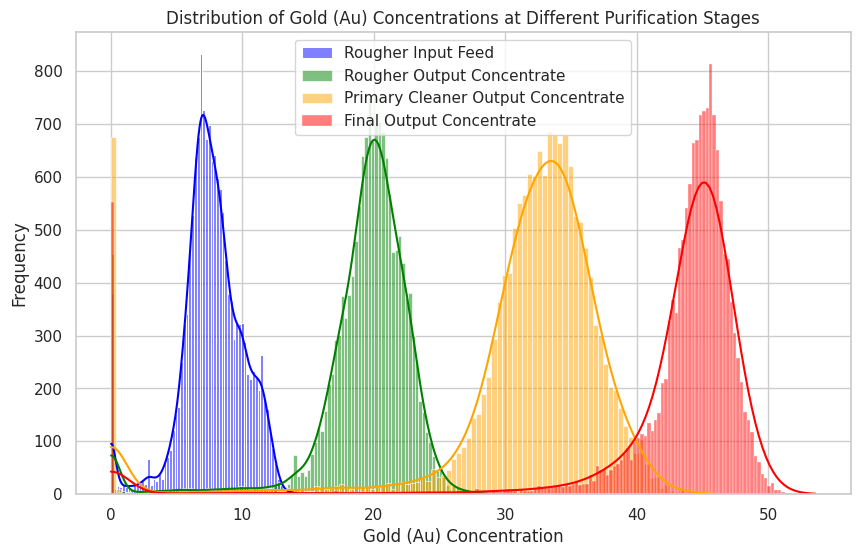

In [36]:
sns.set(style="whitegrid")

#histogram for Au concentrations at different stages
plt.figure(figsize=(10, 6))

# histograms for each stage
sns.histplot(df_1['rougher.input.feed_au'], color='blue', label='Rougher Input Feed', kde=True, alpha=0.5)

sns.histplot(df_1['rougher.output.concentrate_au'], color='green', label='Rougher Output Concentrate', kde=True, alpha=0.5)

sns.histplot(df_1['primary_cleaner.output.concentrate_au'], color='orange', label='Primary Cleaner Output Concentrate', kde=True, alpha=0.5)

sns.histplot(df_1['final.output.concentrate_au'], color='red', label='Final Output Concentrate', kde=True, alpha=0.5)

# labels and title
plt.xlabel('Gold (Au) Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of Gold (Au) Concentrations at Different Purification Stages')
plt.legend()

plt.show()

**In the above hist() we see how the gold concentration change as the mineral go thru the process of purification.The rougher input feed who is the first stage show a high count of occurence with the peak just a bit above 800 and a small gold concentration.
As we move to the second and third stage the rougher output concentrate and the primary cleaner output concentrate we notice a small decrease in the count of occurencie due to the filtration of some undesirables minerals and also notice and increase of the gold concentration.At the final stage we see that the final output concentrate have decrease even futher on the count of occurencies and increase in gold concentration.**

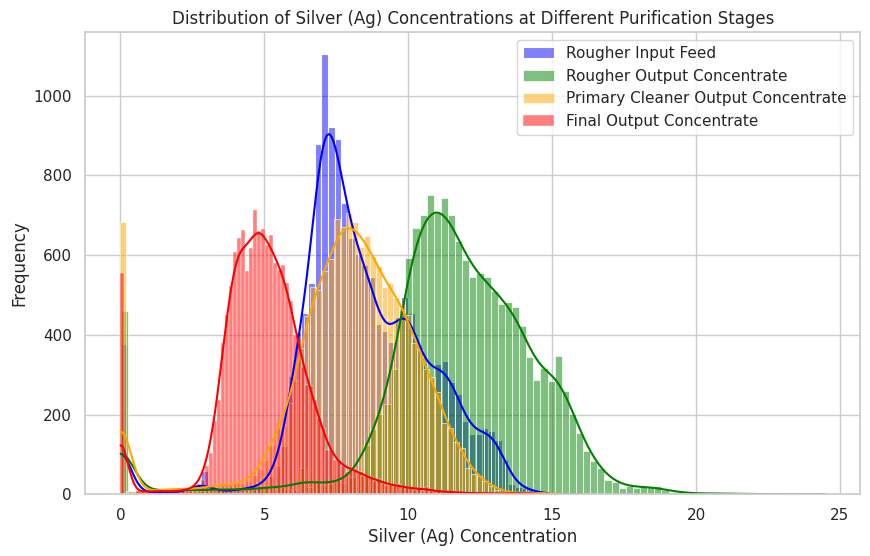

In [37]:
sns.set(style="whitegrid")

# histogram for Ag concentrations at different stages
plt.figure(figsize=(10, 6))

# histograms for each stage
sns.histplot(df_1['rougher.input.feed_ag'], color='blue', label='Rougher Input Feed', kde=True, alpha=0.5)
sns.histplot(df_1['rougher.output.concentrate_ag'], color='green', label='Rougher Output Concentrate', kde=True, alpha=0.5)
sns.histplot(df_1['primary_cleaner.output.concentrate_ag'], color='orange', label='Primary Cleaner Output Concentrate', kde=True, alpha=0.5)
sns.histplot(df_1['final.output.concentrate_ag'], color='red', label='Final Output Concentrate', kde=True, alpha=0.5)

# labels and title
plt.xlabel('Silver (Ag) Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of Silver (Ag) Concentrations at Different Purification Stages')
plt.legend()

plt.show()

**The distribution for Rougher Input Feed with the high count of occurency that peaks above 1000 is spread across a range of concentrations with peaks around 7.**
**The distribution for Rougher Output with a noticeable decrease in count of occurency is more concentrated around a range values with a peak around 12.**
**The distribution for Primary Cleaner Output Concentrate with a futher decrease in count of occurency,with a of concentration peak around 8**
**The distribution for Final Output Concentrate is very narrow, with a sharp peak between (4-5).**
**The histograms overlap significantly,indicating that these concentrations are common across all stages however the final stage has the least overlap.**

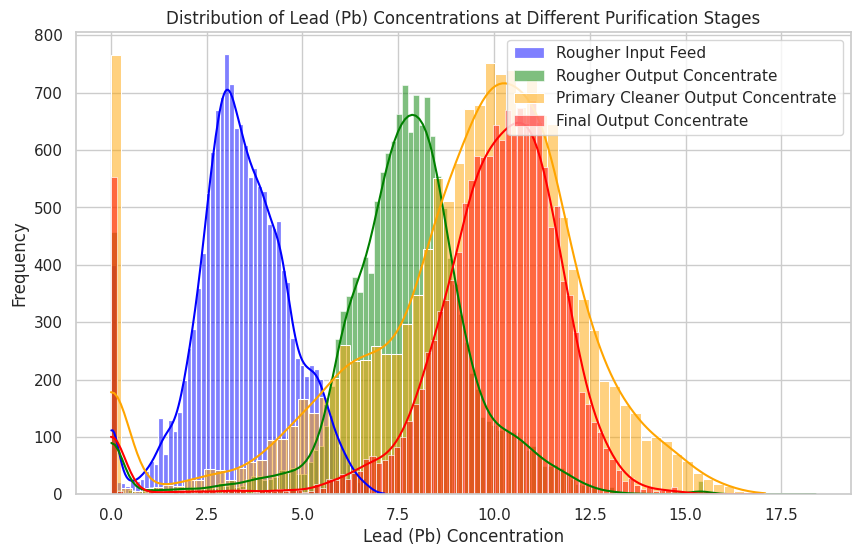

In [38]:
sns.set(style="whitegrid")

# histogram for Pb concentrations at different stages
plt.figure(figsize=(10, 6))

# histograms for each stage
sns.histplot(df_1['rougher.input.feed_pb'], color='blue', label='Rougher Input Feed', kde=True, alpha=0.5)
sns.histplot(df_1['rougher.output.concentrate_pb'], color='green', label='Rougher Output Concentrate', kde=True, alpha=0.5)
sns.histplot(df_1['primary_cleaner.output.concentrate_pb'], color='orange', label='Primary Cleaner Output Concentrate', kde=True, alpha=0.5)
sns.histplot(df_1['final.output.concentrate_pb'], color='red', label='Final Output Concentrate', kde=True, alpha=0.5)

# labels and title
plt.xlabel('Lead (Pb) Concentration')
plt.ylabel('Frequency')
plt.title('Distribution of Lead (Pb) Concentrations at Different Purification Stages')
plt.legend()

plt.show()

**The distribution for the Rougher Input Feed with a count of occurency above 700 is spread across a range of concentrations with peaks around 3.**
**The distribution for the Rougher Output with a noticeable decrease count of occurency is more concentrated around values with a peak around 7.5.**
**The distribution for the Primary Cleaner Output with a slight increase in count of occurency and with a peak around 10.**
**The distribution for the Final Output Concentrate with a narrow decrease in count of occurency, with a sharp peak around 11.**
**The histograms also display some overlap which could indicating that these concentrations are common across certains stages.**

**The following columns rougher.output.concentrate_au, rougher.output.concentrate_ag, rougher.output.concentrate_pb indicate that the concentrations of Au, Ag, and Pb in the rougher concentrate are relatively high compared to the feed, as this stage aims to maximize metal recovery.**

**The primary cleaner stage refines the rougher concentrate further.The concentrations of Au, Ag, and Pb in the primary cleaner concentrate are expected to be higher than in the rougher concentrate, as more impurities are removed.**

**The final stage produces the highest purity concentrate.The concentrations of Au, Ag, and Pb in the final concentrate are the highest among all stages, as most impurities have been removed.**


<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Correct. Great work!
    
</div>

# 2.2  Compare the feed particle size distributions in the training set and in the test set. 

**Feed particle size distributions in the training set.**

In [39]:
feed_size_stats = df_1['primary_cleaner.input.feed_size'].describe()
display(feed_size_stats)

count    15323.000000
mean         7.304705
std          0.614750
min          1.080000
25%          6.930000
50%          7.290000
75%          7.680000
max         10.470000
Name: primary_cleaner.input.feed_size, dtype: float64

**Feed particle size distributions in the test set.**

In [40]:
feed_size_stats = df_2['primary_cleaner.input.feed_size'].describe()
display(feed_size_stats)

count    5856.000000
mean        7.264651
std         0.611526
min         5.650000
25%         6.885625
50%         7.259333
75%         7.650000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

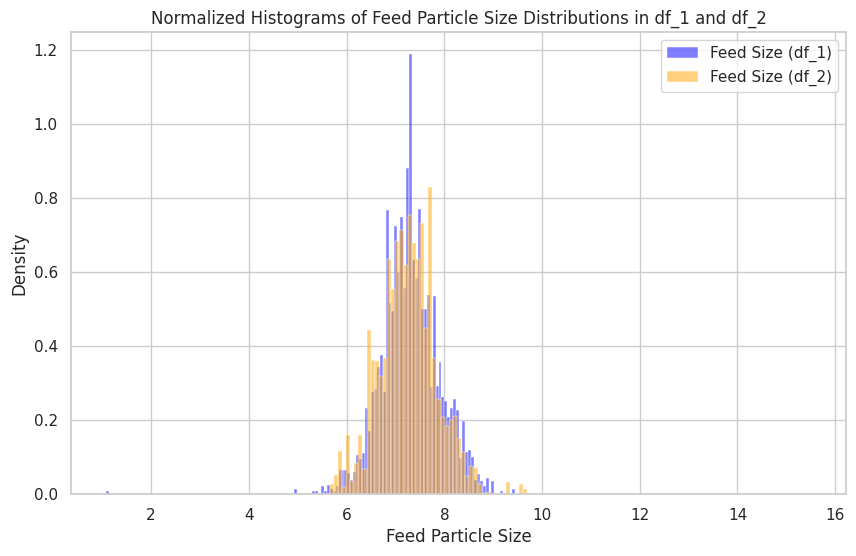

In [41]:
sns.set(style="whitegrid")

# figure and axis
plt.figure(figsize=(10, 6))

# normalized histograms for feed particle size distributions
sns.histplot(df_1['primary_cleaner.input.feed_size'], color='blue', label='Feed Size (df_1)', kde=False, stat='density', alpha=0.5)
sns.histplot(df_2['primary_cleaner.input.feed_size'], color='orange', label='Feed Size (df_2)', kde=False, stat='density', alpha=0.5)

#labels and title
plt.xlabel('Feed Particle Size')
plt.ylabel('Density')
plt.title('Normalized Histograms of Feed Particle Size Distributions in df_1 and df_2')
plt.legend()

plt.show()

**The distribution for df_1 is slightly skewed to the left, with a peak around 7 and density decreases as the particle size increases beyond 7.**
**he distribution for df_2 is more symmetric with a peak around 7.5 and the density is relatively consistent between 7 and 8, with a sharper drop-off beyond 8.**
**df_1 tends to have smaller feed particle sizes compared to df_2.**

**The mean values are very close in both datasets, indicating that the central tendency of the feed particle size distribution could be similar.The standard deviation is nearly identical, suggesting that the variability in feed particle sizes is consistent between the training and test sets.The higher maximum value in the test set could indicate outliers presence.The test set is smaller than the training set, which is typical in ML. However, the distributions are still comparable.**

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Good job!
    
</div>

# 2.3 The total distribution

**total concentrations for each stage in training set.**

**Total Concentrations in Raw Feed.**

In [42]:
raw_feed_columns = [
    'rougher.input.feed_ag', 
    'rougher.input.feed_pb', 
    'rougher.input.feed_sol', 
    'rougher.input.feed_au'
]

total_raw_feed = df_1[raw_feed_columns].sum().sum()
display(total_raw_feed)

831826.5816893266

**Total Concentrations in Rougher Concentrate.**

In [43]:
rougher_concentrate_columns = [
    'rougher.output.concentrate_ag', 
    'rougher.output.concentrate_pb', 
    'rougher.output.concentrate_sol', 
    'rougher.output.concentrate_au'
]

total_rougher_concentrate = df_1[rougher_concentrate_columns].sum().sum()
display(total_rougher_concentrate)

1011689.3338555307

**Total Concentrations in Final Concentrate.**

In [44]:
final_concentrate_columns = [
    'final.output.concentrate_ag', 
    'final.output.concentrate_pb', 
    'final.output.concentrate_sol', 
    'final.output.concentrate_au'
]


total_final_concentrate = df_1[final_concentrate_columns].sum().sum()
display(total_final_concentrate)

1009721.3211793231

**total concentrations for each stage in test set.**

In [45]:
# columns for each stage
raw_feed_columns = [
    'rougher.input.feed_ag', 
    'rougher.input.feed_pb', 
    'rougher.input.feed_sol', 
    'rougher.input.feed_au'
]

# Calculate total concentration for raw feed in the test set
total_concentration_raw_feed = df_2[raw_feed_columns].sum().sum()

display(f"Total concentration for raw feed in test set: {total_concentration_raw_feed}")

'Total concentration for raw feed in test set: 327501.9454665845'

In [46]:
# Training set
train_raw_feed_stats = df_1[raw_feed_columns].sum(axis=1).describe()

# Test set
test_raw_feed_stats = df_2[raw_feed_columns].sum(axis=1).describe()

# Combine the results into a DataFrame for easy comparison
comparison_stats = pd.DataFrame({
    'Training Set': train_raw_feed_stats,
    'Test Set': test_raw_feed_stats
})

display(comparison_stats)

,Training Set,Test Set
count,15323.000000,5856.000000
mean,54.286144,55.925879
std,12.000724,16.559002
min,0.040000,0.000000
25%,51.770698,55.416599
50%,56.351996,59.385485
75%,60.634836,64.656589
max,76.024095,76.978947


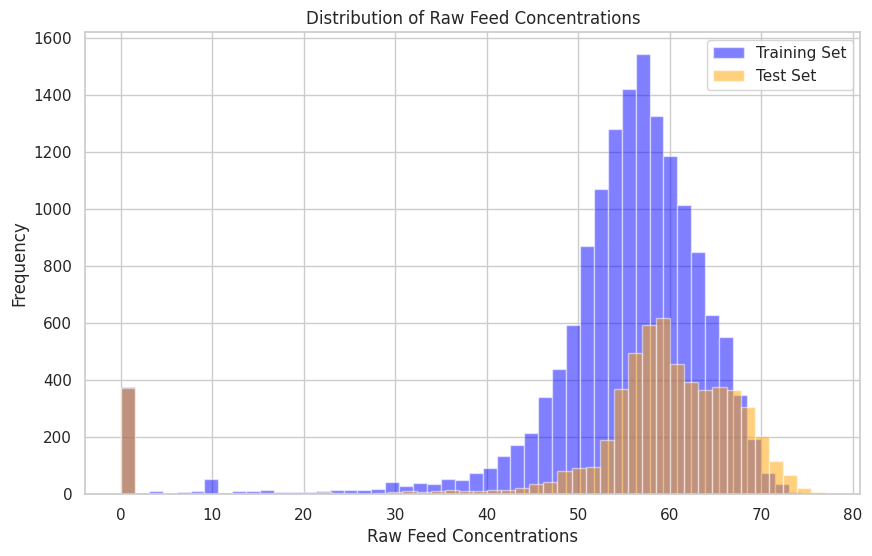

In [47]:
# total raw feed concentrations for training and test sets
train_raw_feed = df_1[raw_feed_columns].sum(axis=1)
test_raw_feed = df_2[raw_feed_columns].sum(axis=1)

# histograms
plt.figure(figsize=(10, 6))
plt.hist(train_raw_feed, bins=50, alpha=0.5, label='Training Set', color='blue')
plt.hist(test_raw_feed, bins=50, alpha=0.5, label='Test Set', color='orange')

# labels and title
plt.title('Distribution of Raw Feed Concentrations')
plt.xlabel('Raw Feed Concentrations')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

**The above hist() indicate a big discrepancie in size between the training set and the test set. We also notice the presence of some gaps between the data point. This could be an indicator of missing values or a non continuous distribution.**

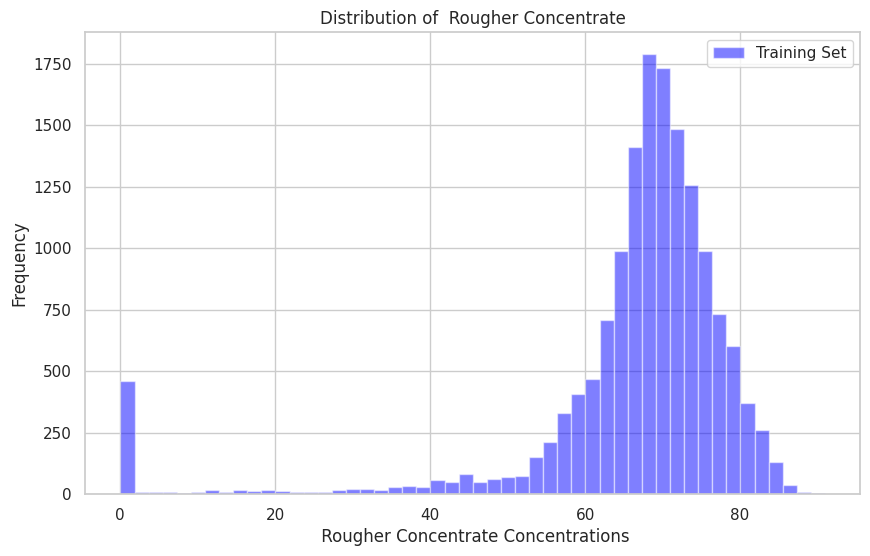

In [48]:
# total Rougher Concentrate for training and test sets
train_Rougher_Concentrate = df_1[rougher_concentrate_columns].sum(axis=1)
#test_Rougher_Concentrate = df_2[rougher_concentrate_columns].sum(axis=1)

# histograms
plt.figure(figsize=(10, 6))
plt.hist(train_Rougher_Concentrate, bins=50, alpha=0.5, label='Training Set', color='blue')
#plt.hist(test_Rougher_Concentrate, bins=50, alpha=0.5, label='Test Set', color='orange')

# labels and title
plt.title('Distribution of  Rougher Concentrate')
plt.xlabel(' Rougher Concentrate Concentrations')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

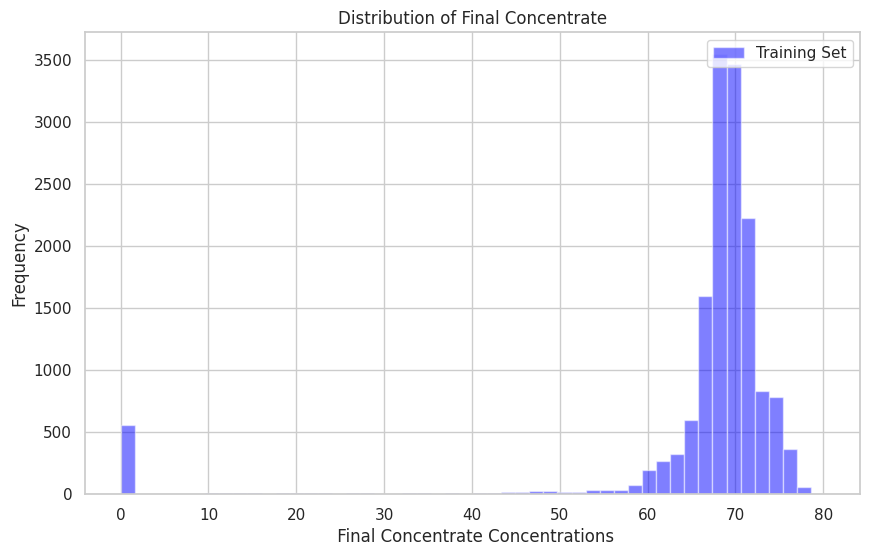

In [49]:
# total Final Concentrate for training
train_Final_Concentrate = df_1[final_concentrate_columns].sum(axis=1)
#test_Final_Concentrate = df_2[final_concentrate_columns].sum(axis=1)

# histograms
plt.figure(figsize=(10, 6))
plt.hist(train_Final_Concentrate, bins=50, alpha=0.5, label='Training Set', color='blue')
#plt.hist(test_Final_Concentrate, bins=50, alpha=0.5, label='Test Set', color='orange')

# labels and title
plt.title('Distribution of Final Concentrate')
plt.xlabel(' Final Concentrate Concentrations')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

**Yes there is an abnormal value in the total distribution of raw feed concentrations between the training set and the test set.
The hist. indicate that the test set distribution have a small dispersion compare to the training set.** 

**Anomalies:**

**The presence of gaps in the data set this could suggest missing values or a non-continuous distribution..**

**The presence of zero values in the test set is a potential issue.**



In [50]:
# Select columns as a list
df_1['final_concentrate_columns'] = df_1[['final.output.concentrate_ag', 
                                           'final.output.concentrate_pb', 
                                           'final.output.concentrate_sol', 
                                           'final.output.concentrate_au']].sum(axis=1)

df_1['rougher_concentrate_columns'] = df_1[['rougher.output.concentrate_ag', 
                                             'rougher.output.concentrate_pb', 
                                             'rougher.output.concentrate_sol', 
                                             'rougher.output.concentrate_au']].sum(axis=1)

In [51]:
zero_values_df_2 = df_2[df_2[raw_feed_columns].sum(axis=1) == 0.00]
#display(zero_values_df_2)

In [52]:
zero_values_df_1 = df_1[df_1[['final_concentrate_columns', 'rougher_concentrate_columns']].sum(axis=1) == 0.00]

#display(zero_values_df_1)

In [53]:
# Remove rows where raw feed concentrations are zero
df_2 = df_2[df_2[raw_feed_columns].sum(axis=1) != 0]

In [54]:
# Let verify that zero values have been handled
display("Rows with zero values after removal:", df_2[df_2[raw_feed_columns].sum(axis=1) == 0].shape[0])

'Rows with zero values after removal:'

0

In [55]:
# Remove rows where raw feed concentrations are zero
df_1 = df_1[df_1[['final_concentrate_columns', 'rougher_concentrate_columns']].sum(axis=1) != 0.00]

In [56]:
# Let verify that zero values have been handled
display("Rows with zero values after removal:", df_1[df_1[['final_concentrate_columns', 'rougher_concentrate_columns']].sum(axis=1) == 0].shape[0])

'Rows with zero values after removal:'

0

# 3. Build the model

**check recovery for the final.output.recovery feature.**

In [57]:
#df_1.info()

In [58]:
#df_2.info()

In [59]:
# Extracting the relevant columns
C_1 = df_1['final.output.concentrate_au']
F_1 = df_1['rougher.input.feed_au']
T_1 = df_1['rougher.output.tail_au']

In [60]:
recover_1 = C_1 * (F_1 - T_1)
recover_2 = F_1 * (C_1 - T_1)
df_1['check.final.output.recovery'] = (recover_1 / recover_2 ) * 100

In [61]:
display(df_1[['final.output.recovery', 'check.final.output.recovery']].head())

,final.output.recovery,check.final.output.recovery
0,70.541216,84.295844
1,69.266198,84.043553
2,68.116445,84.016854
3,68.347543,84.488705
4,66.927016,84.111780


**The gap is big.**

In [62]:
# Remove rows where raw feed concentrations are zero
df_1 = df_1[df_1[['final.output.recovery', 'check.final.output.recovery']].sum(axis=1) != 0.00]

In [63]:
# Let verify that zero values have been handled
display("Rows with zero values after removal:", df_1[df_1[['final.output.recovery', 'check.final.output.recovery']].sum(axis=1) == 0].shape[0])

'Rows with zero values after removal:'

0

**3.1. Write a function to calculate the final sMAPE value.**

In [64]:
def sMAPE(actual, prediction):
    actual = np.array(actual).ravel()
    prediction = np.array(prediction).ravel()
    denominator = (np.abs(actual) + np.abs(prediction)) + 1e-10
    return 2 * np.mean(np.abs(prediction - actual) / denominator) * 100

In [65]:
def final_sMAPE(actual, prediction):
    # Extract the relevant columns from actual (final output) and prediction (rougher output)
    actual_rougher = actual['rougher.output.recovery']  # Access using column name
    actual_final = actual['final.output.recovery']  # Access using column name

    pred_rougher = prediction['rougher.output.recovery']  # Access using column name
    pred_final = prediction['final.output.recovery']  # Access using column name

    # Calculate sMAPE for both rougher and final recovery
    sMAPE_rougher = sMAPE(actual_rougher, pred_rougher)
    sMAPE_final = sMAPE(actual_final, pred_final)

    # Perform weighted final sMAPE calculation
    final_sMAPE = 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

    return final_sMAPE

**3.2. Train different models.**

In [66]:
df_2_features = df_2.drop(columns=['date'])  # Match shape (52 columns)

In [67]:
features_to_keep = df_2.columns.drop('date')

**Linear Regression.**

In [68]:
# Features: Exclude 'date' 
features_train = df_1[features_to_keep]

# Targets
target_train = df_1[['rougher.output.recovery', 'final.output.recovery']]

# Drop rows where targets are NaN or zero
target_train = target_train.dropna()
target_train = target_train[(target_train != 0).all(axis=1)]

# Align features with cleaned targets
features_train = features_train.loc[target_train.index]

# Scale features
scaler_features = StandardScaler()
features_scaled = scaler_features.fit_transform(features_train)

# Train model and predict
model = LinearRegression()
#scores = cross_val_score(model, features_scaled, target_train, cv=5)
target_pred = cross_val_predict(model, features_scaled, target_train, cv=5)

# Convert predictions to DataFrame (required for final_sMAPE)
target_pred = pd.DataFrame(
    target_pred, 
    columns=['rougher.output.recovery', 'final.output.recovery'],
    index=target_train.index  # Preserve index alignment
)

# Compute final_sMAPE
final_smape = final_sMAPE(target_train, target_pred)
display(f"Final sMAPE: {final_smape:.2f}%")

'Final sMAPE: 12.03%'

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Correct
    
</div>

**DecisionTreeRegressor.**

**With tune hyperparameter(max_depth).**

In [69]:
# SMAPE scorer (note: lower is better, we negate it for GridSearchCV)
smape_scorer = make_scorer(sMAPE, greater_is_better=False)

# parameter grid for tuning min_samples_split, min_samples_leaf, and max_depth
param_grid = {
    'max_depth': [3, 5, 10],  
    'min_samples_split': [2, 5, 20],  
    'min_samples_leaf': [1, 2, 10], 
}

# DecisionTreeRegressor instance
dt_regressor = DecisionTreeRegressor(random_state=12345)

# Grid Search with 3-fold cross-validation and SMAPE scoring
grid_search = GridSearchCV(
    dt_regressor, 
    param_grid, 
    cv=3, 
    scoring=smape_scorer,  # Using custom SMAPE scorer
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(features_scaled, target_train)

# best model from the grid search
best_model = grid_search.best_estimator_

# Display the best hyperparameters found by GridSearchCV
display("Best Hyperparameters found by GridSearchCV:")
display(grid_search.best_params_)

'Best Hyperparameters found by GridSearchCV:'

{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

<div class="alert alert-block alert-success">
<b>Reviewer's comment V3</b> <a class="tocSkip"></a>

Good job!
    
</div>

In [70]:
# Best hyperparameters
best_params = {
    'max_depth': 5,
    'min_samples_leaf': 10, 
    'min_samples_split': 2
}

# put both models in one line using dictionary comprehension
models = {
    target: DecisionTreeRegressor(
        random_state=12345,
        **best_params
    )
    for target in ['rougher.output.recovery', 'final.output.recovery']
}

# Prepare data
features_train = df_1[features_to_keep]
target_train = df_1[['rougher.output.recovery', 'final.output.recovery']]
features_scaled = StandardScaler().fit_transform(features_train)

# predictions for both targets
target_pred = pd.DataFrame({
    target: cross_val_predict(model, features_scaled, target_train[target], cv=5)
    for target, model in models.items()
}, index=target_train.index)

# sMAPE
final_smape = final_sMAPE(target_train, target_pred)
display(f"Final sMAPE: {final_smape:.2f}%")

'Final sMAPE: 10.36%'

**Random Forest Regressor.**

In [71]:
# Initialize variables to track the best model and result
best_model = None
best_smape = float('inf')  # Initialize to a large value (we want to minimize sMAPE)

# Define the parameters
params = {
    'n_estimators': 100,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'random_state': 12345
}

# Feature and target data
features_train = df_1[features_to_keep]
target_train = df_1[['rougher.output.recovery', 'final.output.recovery']]

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_train)
features_scaled = pd.DataFrame(features_scaled, 
                             columns=features_train.columns, 
                             index=features_train.index)

kf = KFold(n_splits=5, shuffle=True, random_state=12345)

for fold, (train_idx, val_idx) in enumerate(kf.split(features_scaled), 1):
    display(f"\nProcessing Fold {fold}")
    
    # Split data
    X_train, X_val = features_scaled.iloc[train_idx], features_scaled.iloc[val_idx]
    y_train, y_val = target_train.iloc[train_idx], target_train.iloc[val_idx]
    
    # Train model
    model = RandomForestRegressor(**params).fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict(X_val)
    y_pred = pd.DataFrame(y_pred,
                        columns=['rougher.output.recovery', 'final.output.recovery'],
                        index=y_val.index)
    
    # Calculate and display fold sMAPE
    fold_smape = final_sMAPE(y_val, y_pred)
    display(f"Fold {fold} sMAPE: {fold_smape:.2f}%")
    
    # Track best model
    if fold_smape < best_smape:
        best_smape = fold_smape
        best_model = model
        display(f"New best model found with sMAPE: {best_smape:.2f}%")

# Final evaluation on full training set
final_model = RandomForestRegressor(**params).fit(features_scaled, target_train)
train_pred = final_model.predict(features_scaled)
train_pred = pd.DataFrame(train_pred,
                        columns=['rougher.output.recovery', 'final.output.recovery'],
                        index=target_train.index)

final_train_smape = final_sMAPE(target_train, train_pred)
display(f"\nFinal Model Training sMAPE: {final_train_smape:.2f}%")
display(f"Best Fold Model Validation sMAPE: {best_smape:.2f}%")


'\nProcessing Fold 1'

'Fold 1 sMAPE: 5.63%'

'New best model found with sMAPE: 5.63%'

'\nProcessing Fold 2'

'Fold 2 sMAPE: 5.50%'

'New best model found with sMAPE: 5.50%'

'\nProcessing Fold 3'

'Fold 3 sMAPE: 5.40%'

'New best model found with sMAPE: 5.40%'

'\nProcessing Fold 4'

'Fold 4 sMAPE: 5.65%'

'\nProcessing Fold 5'

'Fold 5 sMAPE: 5.41%'

'\nFinal Model Training sMAPE: 3.34%'

'Best Fold Model Validation sMAPE: 5.40%'

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Correct
    
</div>

**From training models we observed that the best one is the Random Forest Regressor.**

# Let use the test sample.

In [72]:
features_train = df_1[features_to_keep]

# Merge df_2 (test data) with df_3 (full data) based on 'date'
df_merged = pd.merge(df_2, df_3[['date', 'rougher.output.recovery', 'final.output.recovery']], 
                     on='date', 
                     how='inner')

# Remove rows where target_rougher_test or target_final_test is zero
df_merged = df_merged[(df_merged['rougher.output.recovery'] != 0) & 
                      (df_merged['final.output.recovery'] != 0)]

# Extract the target variables for test data
target_final_test = df_merged[['final.output.recovery', 'rougher.output.recovery']]

# Scale the test features using the same scaler from training
features_test = df_merged[features_to_keep]
features_test_scaled = scaler.transform(features_test)

# Use the best fold model directly (already trained during CV)
# NO NEED TO RETRAIN - best_model is already the best performing trained model from CV folds
pred_test = best_model.predict(features_test_scaled)

# Convert predictions to DataFrame
predictions = pd.DataFrame(pred_test, 
                          columns=['rougher.output.recovery', 'final.output.recovery'], 
                          index=df_merged.index)

# Calculate final_sMAPE
final_smape_test = final_sMAPE(target_final_test, predictions)

# Display results
display(f"Best Model Validation sMAPE (from CV): {best_smape:.2f}%")
display(f"Test Data sMAPE: {final_smape_test:.2f}%")


'Best Model Validation sMAPE (from CV): 5.40%'

'Test Data sMAPE: 7.70%'

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Good job!
    
</div>

**Sanity check.**

In [73]:
# Calculate mean recovery values from training data
constant_rougher = target_train['rougher.output.recovery'].mean()
constant_final = target_train['final.output.recovery'].mean()

# Create constant predictions (same prediction for all test samples)
constant_predictions = pd.DataFrame({
    'rougher.output.recovery': [constant_rougher] * len(target_final_test),
    'final.output.recovery': [constant_final] * len(target_final_test)
}, index=target_final_test.index)

# Calculate sMAPE for constant model
constant_smape = final_sMAPE(target_final_test, constant_predictions)
display(f"Constant Model sMAPE (Test Data): {constant_smape:.2f}%")

# Compare with your best model
display(f"Your Best Model sMAPE: {final_smape_test:.2f}%")
display(f"Improvement over Constant Model: {constant_smape - final_smape_test:.2f} percentage points")

'Constant Model sMAPE (Test Data): 7.90%'

'Your Best Model sMAPE: 7.70%'

'Improvement over Constant Model: 0.20 percentage points'

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>

Well done!
    
</div>

# Conclusion

**It appears that the predicted rougher recovery values are consistently higher than the predicted final recovery values which is understandable because the rougher still have some extra mineral in it content, while the final recovery is the result after all the processing stages, so it might be a bit lower due to filtration in later stages.** 